In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr
from sklearn import linear_model
import pickle

In [25]:
%matplotlib inline

# Observational sensitivities

In [26]:
def calc_sensitivity_linreg(infiles, del_precip, del_tas, ):
    
    ds_rof = xr.open_mfdataset(infiles, parallel=True)
    da_rof = ds_rof['QRUNOFF'].sel(time=tdelta).mean(axis=(1,2)).compute()
    qrunoff = da_rof.resample(time='A-SEP').mean()
    del_qrunoff = (qrunoff-qrunoff.mean())/qrunoff.mean()*100
    X = np.stack([del_precip.data,
                  del_tas.data,
                  np.ones((del_tas.size))
                 ])
    Y = del_qrunoff.data
    reg = linear_model.LinearRegression()
    reg.fit(X.T, Y)
    a, b, s = reg.coef_
    alpha = a/(1-s)
    beta = b/(1-s)
    return alpha, beta

# prepare USGS observations (in .txt format)
def read_qobs(stids, tag, tdelta, areas, ):
    # Path to usgs discharge file
    df = pd.read_csv('/glade/work/elkoukah/inputs/obs/CR/%s.txt'%stids[tag], skiprows=30, delimiter='\t', names=['org','stid','time','q','flag'])
    df = df[1:]
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    df['q'][df['q']=='Ice'] = np.nan
    daq = df['q'].astype(float).to_xarray()
    qobs = daq.sel(time=tdelta)*0.02832 #ft^3/s to m^3/s
    qobs = qobs.sel(time=~((qobs.time.dt.month == 2) & (qobs.time.dt.day == 29))) #drop leap day
    return qobs

import statsmodels.api as sm
def calc_ci(Y,X,ci):
    lr = sm.OLS(Y, X.T).fit()
    return lr.conf_int(ci)

In [27]:
start_date = "1951-10-01"
end_date = "2010-09-30"
tdelta = slice(start_date, end_date)
areas = {'yampa':1468, 'east':748, 'animas':1819} #km^2
stids = {'yampa':'09239500', 'east':'09112500', 'animas':'09361500'}

In [28]:
dict_sens = {}
dict_sens_ci = {}
dict_forcings = {}
dict_forc_dd = {}
dict_qobs = {}
dict_rofobs = {}
ci = 0.10 # 90% confidence interval

for tag in ('yampa','east','animas'):
    qobs = read_qobs(stids, tag, tdelta, areas, )
    A = areas[tag]
    dict_qobs[tag] = qobs
    
    qobs_dd = qobs/(A*10**6)*1000*24*60**2 #mm/day
    dict_rofobs[tag] = qobs_dd
    qobs_wy = qobs_dd.sel(time=tdelta).resample(time='A-SEP').mean()
    dqobs_wy = (qobs_wy-qobs_wy.mean().data)/qobs_wy.mean().data

    metfile = '/glade/scratch/elkoukah/inputs/%s_livneh_1950-2010.nc'%tag
    ds_met = xr.open_dataset(metfile)
    ds_met_tdelta = ds_met.sel(time=tdelta).isel(lat=0,lon=0)
    prec = ds_met_tdelta['Prec']
    avtemp = (ds_met_tdelta['Tmax']+ds_met_tdelta['Tmin'])/2
    prec_wy = prec.resample(time='A-SEP').mean()
    avtemp_wy = avtemp.resample(time='A-SEP').mean()
    dprec_wy = (prec_wy-prec_wy.mean().data)/prec_wy.mean().data
    davtemp_wy = avtemp_wy-avtemp_wy.mean().data
    dict_forcings[tag] = (dprec_wy, davtemp_wy) 
    dict_forc_dd[tag] =  (prec, avtemp)
    rratio = qobs_wy.mean('time').data/prec_wy.mean('time').data
    
    X = np.stack([dprec_wy.data[1:],
                  davtemp_wy.data[1:],
                  dqobs_wy.data[:-1],
                 ])
    Y = dqobs_wy.data[1:]
    reg = linear_model.LinearRegression()
    reg.fit(X.T, Y)
    a, b, s = reg.coef_
    alpha = a/(1-s)
    beta = b/(1-s)
    dict_sens[tag] = (alpha,beta,rratio,qobs_wy)
    ci_arr = calc_ci(Y,X,ci)
    alpha_ci, beta_ci = ci_arr[0]/(1-ci_arr[-1]), ci_arr[1]/(1-ci_arr[-1])
    dict_sens_ci[tag] = (alpha_ci, beta_ci)
    print(tag, 'alpha:',alpha, 'beta:',beta, 'sigma',s)

yampa alpha: 1.5569380199539664 beta: -0.14185148542334594 sigma 0.1867366351351166
east alpha: 1.6210430640736553 beta: -0.11431736011616882 sigma 0.1645997246900484
animas alpha: 1.5309070085552163 beta: -0.10248833530876886 sigma 0.09727806632631328


# Simulated sensitivities

Steps:
1. Latin Hypercube sampling (N=200 parameter sets) of 37 parameters selected parameters. Check steps 1 and 2 from https://github.com/NCAR/ctsm_optz for parameter screening from Parameter Perturbed experiment output.

2. CLM is run with each parameter set for 1950-2010 (first 2-years for spinup).

3. For each run, runoff sensitivities and ratios are calculated similar to observational estimates. 

In [21]:
# Path to model simulations of runoff sensitivities
infile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/screening_lhs/pe_basin_0_metrics_rratios.pkl'
dict_metrics = pickle.load( open( infile, "rb" ) )

# Figure

Text(0, 0.5, '$\\beta$ [% $\\degree$C$^{-1}$]')

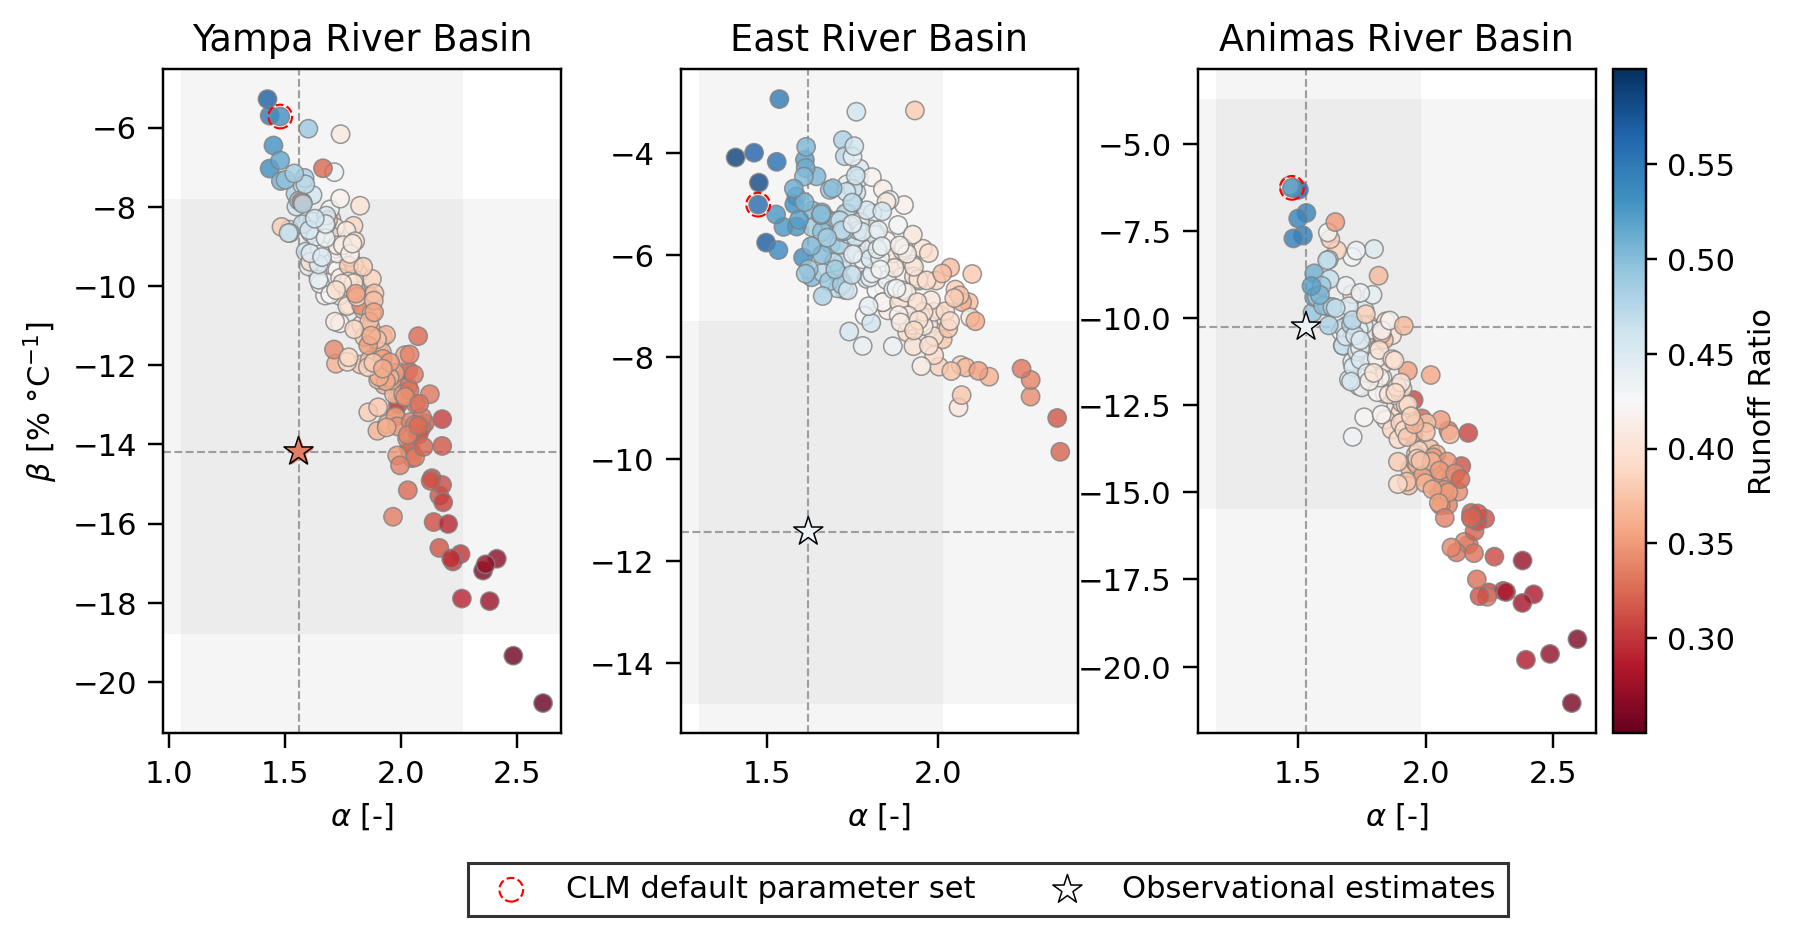

In [17]:
basins = ['yampa', 'east', 'animas']
metric_names = ['metric_alpha', 'metric_beta']
titles = ['Yampa River Basin', 'East River Basin', 'Animas River Basin']
fig, axes = plt.subplots(1,3,figsize=(10,4), dpi=220, gridspec_kw={'wspace':0.3})

norm = mpl.colors.Normalize(vmin=0.25, vmax=0.6)
cmap = mpl.cm.get_cmap('RdBu')
# axes_r = axes.ravel()
for bii in range(3):
    ax = axes[bii]        
    yy = dict_metrics[basins[bii]]['beta']*100
    xx = dict_metrics[basins[bii]]['alpha']
    c=dict_metrics[basins[bii]]['r_ratio']
    sc = ax.scatter(x=xx, y=yy, alpha=.8, c=c, cmap=cmap, edgecolor='grey', lw=.5, norm=norm)
    ax.tick_params(length=5)
    ax.set_title(titles[bii])
    
    alpha_obs = dict_sens[basins[bii]][0]
    alpha_base = dict_metrics[basins[bii]]['alpha'][-1]
    beta_obs = dict_sens[basins[bii]][1]*100
    beta_base = dict_metrics[basins[bii]]['beta'][-1]*100
    rratio = dict_sens[basins[bii]][2]
    alpha_ci, beta_ci = dict_sens_ci[basins[bii]][0], dict_sens_ci[basins[bii]][1]*100
    ax.scatter(alpha_base, beta_base, label='CLM default parameter set', color='None', edgecolor='r', ls='--', lw=.7, marker='o', s=60)
    c = '#9e9e9e'
    ax.scatter(alpha_obs, beta_obs, color=cmap(norm(rratio)), marker='*', s=70)
    ax.scatter(alpha_obs, beta_obs, label='Observational estimates', color='None', edgecolor='k', lw=.5, marker='*', s=100)
    ax.axhspan(beta_ci[0], beta_ci[1], color=c, lw=0.2, alpha=.1, zorder=-1)
    ax.axvspan(alpha_ci[0], alpha_ci[1], color=c, lw=0.2, alpha=.1, zorder=-1)
    ax.axhline(beta_obs, ls='--', color=c, zorder=-1, lw=.7)
    ax.axvline(alpha_obs, ls='--', color=c, zorder=-1, lw=.7)
    
    # rratio_ens = dict_metrics[basins[bii]]['r_ratio']
    # m = (rratio_ens>rratio-0.05)*(rratio_ens<rratio+0.05)
    # ax.scatter(x=xx[m], y=yy[m], alpha=.9, c=rratio_ens[m], cmap=cmap, edgecolor='grey', lw=.5, norm=norm, marker='s')
    
    ax.set_xlabel(r'$\alpha$ [-]')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, label='Runoff Ratio', ticks=np.arange(0.3, 0.6,0.05), ax=axes, pad=0.01)
h,l = ax.get_legend_handles_labels()
fig.legend(h,l, loc='lower center', fancybox=False, bbox_to_anchor=(0.5,-0.1), ncol=3, edgecolor='k')
axes[0].set_ylabel(r'$\beta$ [% $\degree$C$^{-1}$]')